<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Introduction to Feature Engineering
    </h1></td>
    <td width="30%">
    <div style="text-align: right">
    <b> Practical Data Science Lessons</b><br><br>
    <b> Riccardo Bertoglio</b><br>
    <a href="mailto:riccardo.bertoglio@polimi.it">riccardo.bertoglio@polimi.it</a><br>
    </div>
</tr>
</table>

## Learning outcomes 🔎

*   [What is Feature Engineering?](#what_is_feat_eng)
*   [Handling categorical variables](#cat_variables)
*   Handling outliers
*   [Creating features](#create_feat)
*   [Principal Component Analysis](#pca)
*   [Feature selection](#feature_sel)
*   [Mutual information](#mutual_info)

#### More difficult topics are marked with the climbing icon 🧗

#### Resources:
* Books:
    *   *[An Introduction to Statistical Learning](https://www.statlearning.com/)*
    *   *[The Kaggle Book: Data analysis and machine learning for competitive data science](https://www.packtpub.com/en-it/product/the-kaggle-book-9781801817479)*
* From the web:
    *   *[Kaggle Feature Engineering course](https://www.kaggle.com/learn/feature-engineering)*
    *   *[Scikit-learn User Guide: Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)*
    *   *[Scikit-learn User Guide: Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)*
    *   *[Encoding Categorical Variables: A Deep Dive into Target Encoding](https://towardsdatascience.com/encoding-categorical-variables-a-deep-dive-into-target-encoding-2862217c2753)*

<a id='what_is_feat_eng'></a>
## What is Feature Engineering?
Feature engineering is the process of transforming raw data into a format that is more suitable for machine learning models. It involves creating new features, selecting relevant features, and transforming existing features to improve the performance of a model in terms of accuracy and interpretability. Feature engineering is a critical step in the data preprocessing pipeline and plays a key role in enhancing the predictive power of machine learning algorithms.

## Setup the notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.feature_selection import mutual_info_regression
from IPython.display import display
from sklearn.decomposition import PCA

<a id='cat_variables'></a>
## Handling categorical variables

A **categorical variable** takes only a limited number of values.  

- Consider a survey that asks how often you eat breakfast and provides four options: "Never", "Rarely", "Most days", or "Every day".  In this case, the data is categorical, because responses fall into a fixed set of categories.
- If people responded to a survey about which what brand of car they owned, the responses would fall into categories like "Honda", "Toyota", and "Ford".  In this case, the data is also categorical.

You will get an error if you try to plug these variables into most machine learning models in Python without preprocessing them first.  We now compare three basic approaches that you can use to prepare your categorical data.

### 1) Drop Categorical Variables

The easiest approach to dealing with categorical variables is to simply remove them from the dataset.  This approach will only work well if the columns did not contain useful information.

### 2) Ordinal Encoding

**Ordinal encoding** assigns each unique value to a different integer.

![tut3_ordinalencode](https://i.imgur.com/tEogUAr.png)

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories.  Not all categorical variables have a clear ordering in the values, but we refer to those that do as **ordinal variables**.  For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables. 

### 3) One-Hot Encoding

**One-hot encoding** creates new columns indicating the presence (or absence) of each possible value in the original data.  To understand this, we'll work through an example.

![tut3_onehot](https://i.imgur.com/TW5m0aJ.png)

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green".  The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset.  Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.  

In contrast to ordinal encoding, one-hot encoding *does not* assume an ordering of the categories.  Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither _more_ nor _less_ than "Yellow").  We refer to categorical variables without an intrinsic ranking as **nominal variables**.

**One-hot encoding generally does not perform well if the categorical variable takes on a large number of values** (i.e., you generally won't use it for variables taking more than 15 different values). 

### Example

We will work with the Melbourne Housing dataset.  

We won't focus on the data loading step. Instead, you can imagine you are at a point where you already have the training and validation data in `X_train`, `X_valid`, `y_train`, and `y_valid`. 

In [28]:
# Read the data
data = pd.read_csv('data/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

We take a peek at the training data with the `head()` method below. 

In [29]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


Next, we obtain a list of all of the categorical variables in the training data.

We do this by checking the data type (or **dtype**) of each column.  The `object` dtype indicates a column has text (there are other things it could theoretically be, but that's unimportant for our purposes).  For this dataset, the columns with text indicate categorical variables.

In [30]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


### Define Function to Measure Quality of Each Approach

We define a function `score_dataset()` to compare the three different approaches to dealing with categorical variables. This function reports the [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) from a random forest model.  In general, we want the MAE to be as low as possible!

In [31]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Score from Approach 1 (Drop Categorical Variables)

We drop the `object` columns with the [`select_dtypes()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html) method. 

In [32]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):


175703.48185157913


### Score from Approach 2 (Ordinal Encoding)

Scikit-learn has a [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) class that can be used to get ordinal encodings.  We loop over the categorical variables and apply the ordinal encoder separately to each column.

In [33]:
# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):


165936.40548390493


In the code cell above, for each column, we randomly assign each unique value to a different integer.  This is a common approach that is simpler than providing custom labels; however, we can expect an additional boost in performance if we provide better-informed labels for all ordinal variables.

### Score from Approach 3 (One-Hot Encoding)

We use the [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class from scikit-learn to get one-hot encodings.  There are a number of parameters that can be used to customize its behavior.  
- We set `handle_unknown='ignore'` to avoid errors when the validation data contains classes that aren't represented in the training data, and
- setting `sparse=False` ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).

To use the encoder, we supply only the categorical columns that we want to be one-hot encoded.  For instance, to encode the training data, we supply `X_train[object_cols]`. (`object_cols` in the code cell below is a list of the column names with categorical data, and so `X_train[object_cols]` contains all of the categorical data in the training set.)

In [11]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding set feature names as integers; let's convert them
# to strings to avoid errors with learning algorithms
OH_cols_train.columns = OH_cols_train.columns.astype(str)
OH_cols_valid.columns = OH_cols_valid.columns.astype(str)

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

c:\Users\Ticio\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MAE from Approach 3 (One-Hot Encoding):
166089.4893009678


In [12]:
OH_X_train

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount,0,...,6,7,8,9,10,11,12,13,14,15
12167,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.98670,13240.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6524,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.90050,6380.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8413,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.82200,3755.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2919,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.91580,8870.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6043,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.82720,4217.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,3,5.2,3056.0,3.0,1.0,212.0,-37.77695,144.95785,11918.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3264,3,10.5,3081.0,3.0,1.0,748.0,-37.74160,145.04810,2947.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9845,4,6.7,3058.0,4.0,2.0,441.0,-37.73572,144.97256,11204.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10799,3,12.0,3073.0,3.0,1.0,606.0,-37.72057,145.02615,21650.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Which approach is best?

In this case, dropping the categorical columns (**Approach 1**) performed worst, since it had the highest MAE score.  As for the other two approaches, since the returned MAE scores are so close in value, there doesn't appear to be any meaningful benefit to one over the other.

### Target encoding

While one-hot encoding works great for features with limited categories (less than 10–20 categories), as the number of categories increases, the one-hot encoded vectors become longer and sparser, potentially leading to increased memory usage and computational complexity, let’s look at an example.

We will use the 1985 Automobiles dataset. It consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`.

In [20]:
# Load autos data

autos = pd.read_csv("data/autos.csv")

A **target encoding** is any kind of encoding that replaces a feature's categories with some number derived from the target.

A simple and effective version is to apply a group aggregation, like the mean. Using the *Automobiles* dataset, this computes the average price of each vehicle's make:

In [21]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


This kind of target encoding is sometimes called a **mean encoding**. Applied to a binary target, it's also called **bin counting**. (Other names you might come across include: likelihood encoding, impact encoding, and leave-one-out encoding.)

### 🧗 Smoothing

An encoding like this presents a couple of problems, however. First are *unknown categories*. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.

Second are *rare categories*. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. In the *Automobiles* dataset, the `mercurcy` make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

A solution to these problems is to add **smoothing**. The idea is to blend the *in-category* average with the *overall* average. Rare categories get less weight on their category average, while missing categories just get the overall average.

In pseudocode:
```
encoding = weight * in_category + (1 - weight) * overall
```
where `weight` is a value between 0 and 1 calculated from the category frequency.

An easy way to determine the value for `weight` is to compute an **m-estimate**:
```
weight = n / (n + m)
```
where `n` is the total number of times that category occurs in the data. The parameter `m` determines the "smoothing factor". Larger values of `m` put more weight on the overall estimate.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/1uVtQEz.png" width=500, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

In the *Automobiles* dataset there are three cars with the make `chevrolet`. If you chose `m=2.0`, then the `chevrolet` category would be encoded with 60% of the average Chevrolet price plus 40% of the overall average price.
```
chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03
```

When choosing a value for `m`, consider how noisy you expect the categories to be. Does the price of a vehicle vary a great deal within each make? Would you need a lot of data to get good estimates? If so, it could be better to choose a larger value for `m`; if the average price for each make were relatively stable, a smaller value could be okay.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Use Cases for Target Encoding</strong><br>
Target encoding is great for:
<ul>
<li><strong>High-cardinality features</strong>: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.
<li><strong>Domain-motivated features</strong>: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.
</ul>
</blockquote>

To further explore the topic, read the *[Towards Data Science article "Encoding Categorical Variables: A Deep Dive into Target Encoding".](https://towardsdatascience.com/encoding-categorical-variables-a-deep-dive-into-target-encoding-2862217c2753)*

### 🧗 Example - MovieLens1M

The *MovieLens1M* dataset contains one-million movie ratings by users of the MovieLens website, with features describing each user and movie. This cell sets everything up:

In [43]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


df = pd.read_csv("data/movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


With over 3000 categories, the `Zipcode` feature makes a good candidate for target encoding, and the size of this dataset (over one-million rows) means we can spare some data to create the encoding.

We'll start by creating a 25% split to train the target encoder.

In [71]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

The `TargetEncoder` class in `scikit-learn` implements a target encoder, which we'll use to encode our `Zipcode` feature.

In [72]:
# Specify that the target type is continuous since the 'Rating' column has integers and they
# would be interpreted as categorical values otherwise
target_enc = TargetEncoder(categories="auto", target_type="continuous", smooth="auto")

# Fit the encoder on the encoding training split
zipcode_enc = X_encode["Zipcode"].values.reshape(-1,1)
target_enc.fit(zipcode_enc, y_encode.astype(np.int32))

# Encode the Zipcode column to create the final training data
zipcode_pretrain = X_pretrain["Zipcode"].values.reshape(-1,1)
X_train = X_pretrain
X_train["Zipcode"] = target_enc.transform(zipcode_pretrain)

In [75]:
X_train

,Movie ID,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Thriller,Unknown,War,Western,(no genres listed),User ID,Age,Gender,Occupation,Zipcode
3,b'1389',1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,b'2896',18,1,14,3.605320
4,b'3635',1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,b'5264',18,1,17,3.936342
5,b'2042',0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,b'4957',25,1,1,3.230678
6,b'2289',0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,b'5294',25,1,1,3.665625
7,b'3334',0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,b'2064',35,1,0,4.184061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000201,b'2762',0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,b'1934',25,1,18,3.618657
1000203,b'2915',0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,b'3792',25,1,4,3.628173
1000206,b'593',0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,b'5799',25,1,3,3.663385
1000207,b'1693',0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,b'3224',25,0,14,3.795947


Let's compare the encoded values to the target to see how informative our encoding might be.

c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


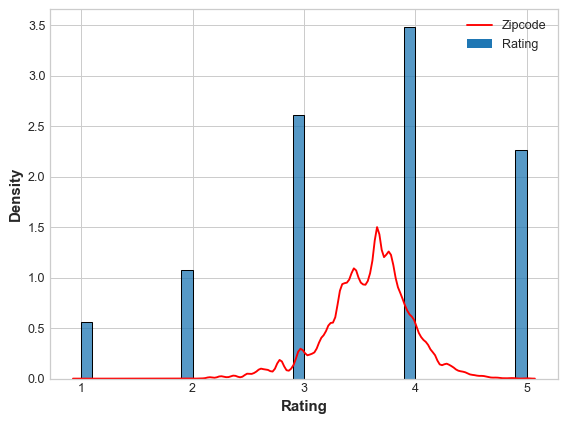

In [87]:
plt.figure(dpi=90)
ax = sns.histplot(y, kde=False, stat='density', binwidth=0.1)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

The distribution of the encoded `Zipcode` feature roughly follows the distribution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode to zipcode that our target encoding was able to capture useful information.

To further explore, there is [a library that contains a set of scikit-learn-style transformers](https://contrib.scikit-learn.org/category_encoders/index.html) for encoding categorical variables with many different techniques.

<a id='create_feat'></a>
## Creating features

The goal of feature engineering is simply to make your data better suited to the problem at hand.

Consider "apparent temperature" measures like the heat index and the wind chill. These quantities attempt to measure the *perceived* temperature to humans based on air temperature, humidity, and wind speed, things which we can measure directly. You could think of an apparent temperature as the result of a kind of feature engineering, **an attempt to make the observed data more relevant to what we actually care about**: how it actually feels outside!

You might perform feature engineering to:
- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

### A Guiding Principle of Feature Engineering

**For a feature to be useful, it must have a relationship to the target that your model is able to learn**. Linear models, for instance, are only able to learn linear relationships. So, **when using a linear model, your goal is to transform the features to make their relationship to the target linear**.

The key idea here is that a transformation you apply to a feature becomes in essence a part of the model itself. Say you were trying to predict the `Price` of square plots of land from the `Length` of one side. Fitting a linear model directly to `Length` gives poor results: the relationship is not linear.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/5D1z24N.png" width=300, alt="A scatterplot of Length along the x-axis and Price along the y-axis, the points increasing in a curve, with a poorly-fitting line superimposed.">
<figcaption style="textalign: center; font-style: italic"><center>A linear model fits poorly with only Length as feature.
</center></figcaption>
</figure>

If we square the `Length` feature to get `'Area'`, however, we create a linear relationship. Adding `Area` to the feature set means this linear model can now fit a parabola. Squaring a feature, in other words, gave the linear model the ability to fit squared features.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/BLRsYOK.png" width=600, alt="Left: Area now on the x-axis. The points increasing in a linear shape, with a well-fitting line superimposed. Right: Length on the x-axis now. The points increase in a curve as before, and a well-fitting curve is superimposed.">
<figcaption style="textalign: center; font-style: italic"><center><strong>Left:</strong> The fit to Area is much better. <strong>Right:</strong> Which makes the fit to Length better as well.
</center></figcaption>
</figure>

This should show you why there can be such a high return on time invested in feature engineering. **Whatever relationships your model can't learn, you can provide yourself through transformations**. As you develop your feature set, think about what information your model could use to achieve its best performance. Once you've identified a set of features with some potential, it's time to start developing them. In the following, you'll learn a number of common transformations you can do entirely in Pandas.

We'll use four datasets in this part having a range of feature types: *US Traffic Accidents*, *1985 Automobiles*, *Concrete Formulations*, and *Customer Lifetime Value*.

In [92]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

accidents = pd.read_csv("data/accidents.csv")
autos = pd.read_csv("data/autos.csv")
concrete = pd.read_csv("data/concrete.csv")
customer = pd.read_csv("data/customer.csv")

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Tips on Discovering New Features</strong>
<ul>
<li>Understand the features. Refer to your dataset's <em>data documentation</em>, if available.
<li>Research the problem domain to acquire <strong>domain knowledge</strong>. If your problem is predicting house prices, do some research on real-estate for instance. Wikipedia can be a good starting point, but books and <a href="https://scholar.google.com/">journal articles</a> will often have the best information.
<li>Use data visualization. Visualization can reveal pathologies in the distribution of a feature or complicated relationships that could be simplified. Be sure to visualize your dataset as you work through the feature engineering process.
<ul>
</blockquote>

### Mathematical Transforms

Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In the *Automobile* dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [93]:
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn, like this formula for an engine's "displacement", a measure of its power:

In [94]:
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)

Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of `WindSpeed` in *US Accidents* is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

C:\Users\Ticio\AppData\Local\Temp\ipykernel_18240\3343200215.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


C:\Users\Ticio\AppData\Local\Temp\ipykernel_18240\3343200215.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);
c:\Users\Ticio\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


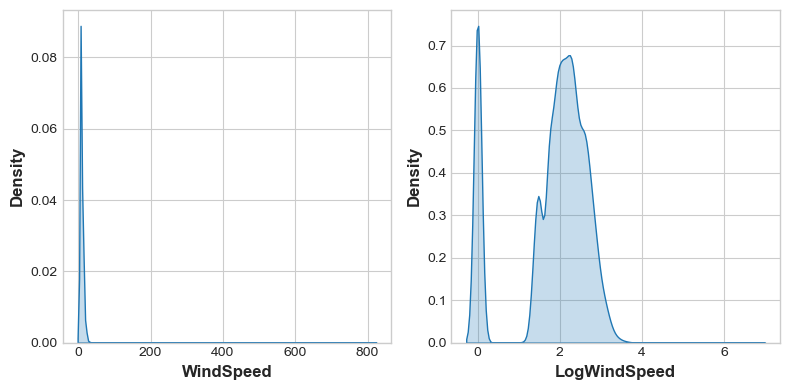

In [95]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

### Counts 

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a **count**.

These features will be *binary* (`1` for Present, `0` for Absent) or *boolean* (`True` or `False`). In Python, booleans can be added up just as if they were integers.

In *Traffic Accidents* are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the `sum` method:

In [96]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


You could also use a dataframe's built-in methods to *create* boolean values. In the *Concrete* dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than `gt` method:

In [97]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


### Building-Up and Breaking-Down Features #

Often you'll have complex strings that can usefully be broken into simpler pieces. Some common examples:
- ID numbers: `'123-45-6789'`
- Phone numbers: `'(999) 555-0123'`
- Street addresses: `'1600 Amphitheatre Parkway, Mountain View, CA 94043'`
- Internet addresses: `'http://www.google.com'`
- Product codes: `'0 36000 29145 2'`
- Dates and times: `'Mon Sep 30 07:06:05 2013'`

Features like these will often have some kind of structure that you can make use of. US phone numbers, for instance, have an area code (the `'(999)'` part) that tells you the location of the caller. As always, some research can pay off here.

The `str` accessor lets you apply string methods like `split` directly to columns. The *Customer Lifetime Value* dataset contains features describing customers of an insurance company. From the `Policy` feature, we could separate the `Type` from the `Level` of coverage:

In [99]:
customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


You could also join simple features into a composed feature if you had reason to believe there was some interaction in the combination:

In [100]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


### Group Transforms

Finally we have **Group transforms**, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that category could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose `State` for the grouping feature, `mean` for the aggregation function, and `Income` for the aggregated feature. To compute this in Pandas, we use the `groupby` and `transform` methods:

In [101]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


The `mean` function is a built-in dataframe method, which means we can pass it as a string to `transform`. Other handy methods include `max`, `min`, `median`, `var`, `std`, and `count`. Here's how you could calculate the frequency with which each state occurs in the dataset:


In [102]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


You could use a transform like this to create a **frequency encoding** for a categorical feature.

#### ⚠ Attention! 
**If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set.**

🧗 We can use the validation set's `merge` method after creating a unique set of values with `drop_duplicates` on the training set:

In [103]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Premium,650.943742
1,Basic,382.929949
2,Basic,382.929949
3,Basic,382.929949
4,Basic,382.929949
5,Basic,382.929949
6,Extended,480.500353
7,Basic,382.929949
8,Premium,650.943742
9,Basic,382.929949


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Tips on Creating Features</strong><br>
It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:
<ul>
<li> Linear models learn sums and differences naturally, but can't learn anything more complex.
<li> Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
<li> Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
<li> Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
<li> Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.
</ul>
</blockquote>

<a id='pca'></a>
## Principal Component Analysis

Principal component Analysis (PCA) is **commonly used for dimensionality reduction by projecting each data point onto only the first few principal components** to obtain lower-dimensional data while preserving as much of the data's variation as possible. PCA is a great tool to help you discover important relationships in the data and **can also be used to create more informative features**.

(Technical note: PCA is typically applied to standardized data. With standardized data, "variation" means "correlation". With unstandardized data "variation" means "covariance")

### Abalone dataset 

In the *Abalone* dataset are physical measurements taken from several thousand Tasmanian abalone. (An abalone is a sea creature much like a clam or an oyster.) We'll just look at a couple features for now: the `'Height'` and `'Diameter'` of their shells.

You could imagine that within this data are **"axes of variation" that describe the ways the abalone tend to differ from one another**. Pictorially, these axes appear as perpendicular lines running along the natural dimensions of the data, one axis for each original feature.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/rr8NCDy.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

Often, we can give names to these axes of variation. The longer axis we might call the "Size" component: small height and small diameter (lower left) contrasted with large height and large diameter (upper right). The shorter axis we might call the "Shape" component: small height and large diameter (flat shape) contrasted with large height and small diameter (round shape).

Notice that instead of describing abalones by their `'Height'` and `'Diameter'`, we could just as well describe them by their `'Size'` and `'Shape'`. This, in fact, is the whole idea of PCA: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/XQlRD1q.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>The principal components become the new features by a rotation of the dataset in the feature space.
</center></figcaption>
</figure>

The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:

```
df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]
```

These new features are called the **principal components** of the data. The weights themselves are called **loadings**. There will be as many principal components as there are features in the original dataset: if we had used ten features instead of two, we would have ended up with ten components.

A component's loadings tell us what variation it expresses through signs and magnitudes:

| Features \ Components | Size (PC1) | Shape (PC2) |
|-----------------------|------------|-------------|
| Height                | 0.707      | 0.707       |
| Diameter              | 0.707      | -0.707      |

This table of loadings is telling us that in the `Size` component, `Height` and `Diameter` vary in the same direction (same sign), but in the `Shape` component they vary in opposite directions (opposite sign). In each component, the loadings are all of the same magnitude and so the features contribute equally in both.

PCA also tells us the *amount* of variation in each component. We can see from the figures that there is more variation in the data along the `Size` component than along the `Shape` component. PCA makes this precise through each component's **percent of explained variance**.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/xWTvqDA.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center> Size accounts for about 96% and the Shape for about 4% of the variance between Height and Diameter.
</center></figcaption>
</figure>

The `Size` component captures the majority of the variation between `Height` and `Diameter`. It's important to remember, however, that the amount of variance in a component doesn't necessarily correspond to how good it is as a predictor: it depends on what you're trying to predict.

### PCA for Feature Engineering

There are two ways you could use PCA for feature engineering.

The first way is to **use it as a descriptive technique**. Since the components tell you about the variation, you could compute the [Mutual information](#mutual_info) scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of `'Height'` and `'Diameter'` if `'Size'` is important, say, or a ratio of `'Height'` and `'Diameter'` if `Shape` is important. You could even try clustering on one or more of the high-scoring components.

The second way is to **use the components themselves as features**. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:
- **Dimensionality reduction**: When your features are highly redundant (*multicollinear*, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- **Anomaly detection**: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- **Noise reduction**: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- **Decorrelation**: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

PCA basically gives you direct access to the correlational structure of your data. You'll no doubt come up with applications of your own!

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>PCA Best Practices</strong><br>
There are a few things to keep in mind when applying PCA:
<ul>
<li> PCA only works with numeric features, like continuous quantities or counts.
<li> PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
<li> Consider removing or constraining outliers, since they can an have an undue influence on the results.
</ul>
</blockquote>

### Example - 1985 Automobiles

In this example, we'll return to our *Automobile* dataset and apply PCA, using it as a descriptive technique to discover features.

The following cell loads the data and defines the functions `plot_variance` and `make_mi_scores`.

In [4]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("data/autos.csv")

We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, `price`. We'll standardize the data since these features aren't naturally on the same scale.

In [5]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

Now we can fit scikit-learn's `PCA` estimator and create the principal components. You can see here the first few rows of the transformed dataset. The transformed values are also called principal component scores.

In [7]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


After fitting, the `PCA` instance contains the loadings in its `components_` attribute. We'll wrap the loadings up in a dataframe.

In [9]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings, by default is (n_components, n_features)
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (`PC1`) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

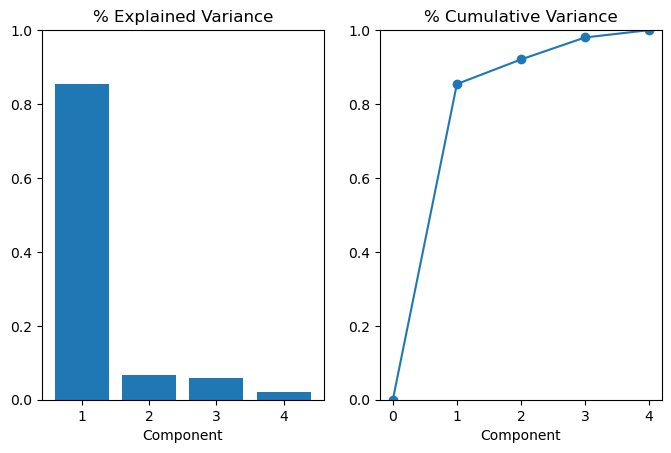

In [10]:
# Look at explained variance
plot_variance(pca);

Let's also look at the MI scores of the components. Not surprisingly, `PC1` is highly informative, though the remaining components, despite their small variance, still have a significant relationship with `price`. Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis.

In [11]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014070
PC2    0.379563
PC3    0.307165
PC4    0.204547
Name: MI Scores, dtype: float64

The third component shows a contrast between `horsepower` and `curb_weight` -- sports cars vs. wagons, it seems.

In [12]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
117,porsche,hardtop,207,2756
118,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


To express this contrast, let's create a new ratio feature:

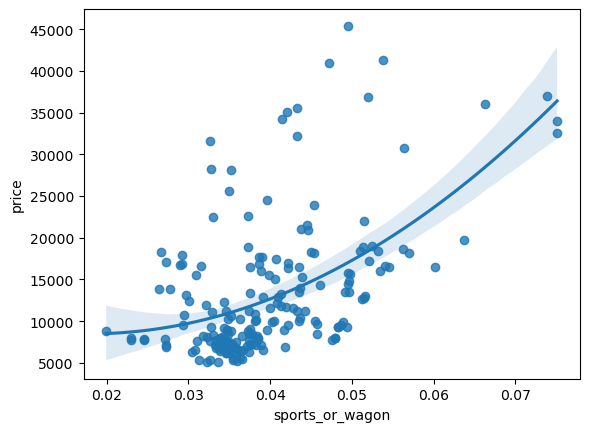

In [14]:
df["sports_or_wagon"] = X.horsepower / X.curb_weight
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);

<a id='feature_sel'></a>
## Feature selection

Feature selection is a method to reduce the variables by using certain criteria to **select variables that are most useful to predict the target by our model**.

Increasing the number of the features helps the model to have a good prediction power, but only until a certain point. This is what we call **Curse of Dimensionality**: the model's performance increases with the higher number of features, but will deteriorate when the feature number is past the peak. That is why we need to select only the features that effectively capable of prediction. **A higher number of dimensions theoretically allow more information to be stored, but practically it rarely helps due to the higher possibility of noise and redundancy in the real-world data**.

Often, in a high dimensional dataset, there remain some entirely irrelevant, insignificant and unimportant features. It has been seen that the contribution of these types of features is often less towards predictive modeling as compared to the critical features. They may have zero contribution as well. These features cause **a number of problems which in turn prevents the process of efficient predictive modeling**:
- Unnecessary resource allocation for these features.
- These features act as a noise for which the machine learning model can perform terribly poorly.
- The machine model takes more time to get trained.

### Feature selection and dimensionality reduction are different!

Sometimes, feature selection is mistaken with dimensionality reduction. But they are different. Feature selection is different from dimensionality reduction. Both methods tend to reduce the number of attributes in the dataset, but a **dimensionality reduction method does so by creating new combinations of attributes (sometimes known as feature transformation), whereas feature selection methods include and exclude attributes present in the data without changing them**.

Some examples of dimensionality reduction methods are Principal Component Analysis, Singular Value Decomposition, Linear Discriminant Analysis, etc.

### Feature selection methods

#### Filter-based methods
![FilterMethods](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1537552825/Image3_fqsh79.png)

Filter method relies on the general uniqueness of the data to be evaluated and pick feature subset, not including any learning algorithm. The filter method uses ranking techniques variable selection. The reason for using the ranking method is the simplicity to produce excellent and relevant features. The ranking method will filter out irrelevant features before any learning algorithm process starts.

Filter methods are generally used as a data preprocessing step. **Features are given a rank on the basis of statistical scores which tend to determine the features' correlation with the outcome variable**. Correlation is a heavily contextual term, and it varies from work to work. Also, you need to consider the kind of your input (features) and output (target) variables when choosing the selection method:
![feature_sel_method.png](https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

Scikit-learn functions for filter-based selection are many:
-  Basic methods (variance filtering)
    - with the `VarianceThreshold` function you can filter out variable with zero o low variance
-  Univariate feature selection
    - `SelectKBest`
    - `SelectPercentile`
    - `SelectFpr`, `SelectFdr`, or family wise error `SelectFwe`
    - `GenericUnivariateSelection`
-  Mutual Information (or information gain)
    - for classification tasks use `mutual_info_classif`
    - for regression tasks use `mutual_info_regression`
-  Fischer score
    - `SelectKBest` with `chi2`
-  ANOVA F-Value for Feature Selection
    - `SelectKBest` with `f_classif` for classification tasks
- Pearson’s Correlation Coefficient
    - `SelectKBest` with `f_regression` for regression tasks
-  Correlation Matrix with Heatmap  
    - Pandas `corr()` method

#### Wrapper methods
![Wrapper Methods](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1537549832/Image2_ajaeo8.png)

As you can see in the above image, a wrapper method needs one learning algorithm and uses its performance as evaluation criteria. This method searches for features which are best-suited for the learning algorithm and aims to improve its performance.

Some typical examples of wrapper methods are forward feature selection, backward feature elimination, recursive feature elimination, etc.
- **Forward Selection**: The procedure starts with an empty set of features reduced set. The best of the original features is determined and added to the reduced set. At each subsequent iteration, the best of the remaining original attributes is added to the set. 
- **Backward Elimination**: The procedure starts with the full set of attributes. At each step, it removes the worst attribute remaining in the set.
- **Exhaustive Feature Selection**: In an exhaustive feature selection the best subset of features is selected, over all possible feature subsets, by optimizing a specified performance metric for a certain machine learning algorithm. For example, if the classifier is a logistic regression and the dataset consists of 4 features, the algorithm will evaluate all 15 feature combinations as follows: all possible combinations of 1 feature, all possible combinations of 2 features, all possible combinations of 3 features, all the 4 features.
- **Recursive Feature elimination**: Recursive feature elimination performs a greedy search to find the best performing feature subset. It iteratively creates models and determines the best or the worst performing feature at each iteration. It constructs the subsequent models with the left features until all the features are explored. It then ranks the features based on the order of their elimination. 

You can implement Forward and Backward Selection with the `SequentialFeatureSelector` function of the module `sklearn.feature_selection`. Recursive Feature Elimination is instead implemented with the `RFE` function of the `sklearn.feature_selection` module. Exhaustive Feature Selection can be implemented with functions of the module `mlxtend`.

#### Embedded methods
![Embedded Methods](https://www.analyticsvidhya.com/wp-content/uploads/2016/11/Embedded_1.png)

Embedded methods are iterative in a sense that they take care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. **Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold**.

This is why regularization methods are also called penalization methods. They introduce additional constraints into the optimization of a predictive algorithm (such as a regression algorithm) that bias the model toward lower complexity (fewer coefficients). Examples of regularization algorithms are the LASSO, Ridge Regression, Decision Trees, etc. 

Embedded methods can be implemented with functions of the `sklearn` module. 

### Difference between filter and wrapper methods

Well, it might get confusing at times to differentiate between filter methods and wrapper methods in terms of their functionalities. Let's take a look at what points they differ from each other.

- Filter methods do not incorporate a machine learning model in order to determine if a feature is good or bad whereas wrapper methods use a machine learning model and train it the feature to decide if it is essential or not.
- Filter methods are much faster compared to wrapper methods as they do not involve training the models. Wrapper methods are computationally costly, and in the case of massive datasets, they might not be the most effective feature selection method to consider.
- Filter methods may fail to find the best subset of features in situations when there is not enough data to model the statistical correlation of the features, but wrapper methods can always provide the best subset of features because of their exhaustive nature.
- Using features from wrapper methods in your final machine learning model can lead to overfitting as wrapper methods already train machine learning models with the features and it affects the true power of learning. Features from filter methods will not lead to overfitting in most of the cases.


### What Is the Best Method?

There is no best feature selection method. Just like there is no best set of input variables or best machine learning algorithm. Instead, we must discover what works best for your specific problem using careful systematic experimentation. We should try a range of different models fit on different subsets of features chosen via different statistical measures and discover what works best for your specific problem.

### Important consideration

You may have already understood the worth of feature selection in a machine learning pipeline but it is very important to understand where you should integrate feature selection in your machine learning pipeline.

Simply speaking, you should include the feature selection step before feeding the data to the model for training, especially when you are using accuracy estimation methods such as cross-validation. This ensures that feature selection is performed only on the training data. But if you perform feature selection first to prepare all your data, then perform model selection and training on the selected features, then it would be a blunder.

If you perform feature selection on all of the data and then cross-validate, then the test data in each fold of the cross-validation procedure was also used to choose the features, and this tends to bias the performance of your machine learning model.

### Transform variables

Consider transforming the variables in order to access different statistical methods. For example, you can transform a categorical variable to ordinal, even if it is not, and see if any interesting results come out. You can also make a numerical variable discrete (e.g. bins); try categorical-based measures.

Some statistical measures assume properties of the variables, such as Pearson’s that assumes a Gaussian probability distribution to the observations and a linear relationship. You can transform the data to meet the expectations of the test and try the test regardless of the expectations and compare results.

<a id='mutual_info'></a>
## Mutual Information

The metric we'll use in the following part of the notebook is the Mutual Information. Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that **it can detect *any* kind of relationship, while correlation only detects *linear* relationships**.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:
- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship

### Mutual Information and What it Measures

Mutual information describes relationships in terms of *uncertainty*. The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Here's an example from the *Ames Housing* data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/X12ARUK.png" width=400, alt="Four categories of ExterQual: Fair, Typical, Good, Excellent. A scatter plot of SalePrice within each category.">
<figcaption style="textalign: center; font-style: italic"><center>Knowing the exterior quality of a house reduces uncertainty about its sale price.
</center></figcaption>
</figure>

From the figure, we can see that knowing the value of `ExterQual` should make you more certain about the corresponding `SalePrice` -- each category of `ExterQual` tends to concentrate `SalePrice` to within a certain range. The mutual information that `ExterQual` has with `SalePrice` is the average reduction of uncertainty in `SalePrice` taken over the four values of `ExterQual`. Since `Fair` occurs less often than `Typical`, for instance, `Fair` gets less weight in the MI score.

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

### Interpreting Mutual Information Scores

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

Here are some things to remember when applying mutual information:
- MI can help you to understand the *relative potential* of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI *can't detect interactions* between features. It is a **univariate** metric.
- The *actual* usefulness of a feature *depends on the model you use it with*. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

### Example - 1985 Automobiles dataset

In this example, we'll rank the features with mutual information and investigate the results by data visualization.

The following cell imports some libraries and loads the dataset.

In [2]:
df = pd.read_csv("data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that *must* have a `float` dtype is *not* discrete. Categoricals (`object` or `categorical` dtype) can be treated as discrete by giving them a label encoding.

In [3]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn has two mutual information metrics in its `feature_selection` module: one for real-valued targets (`mutual_info_regression`) and one for categorical targets (`mutual_info_classif`). Our target, `price`, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [4]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          0.914357
horsepower           0.888088
length               0.611381
fuel_system          0.462229
drive_wheels         0.332645
symboling            0.232860
compression_ratio    0.092484
fuel_type            0.048120
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

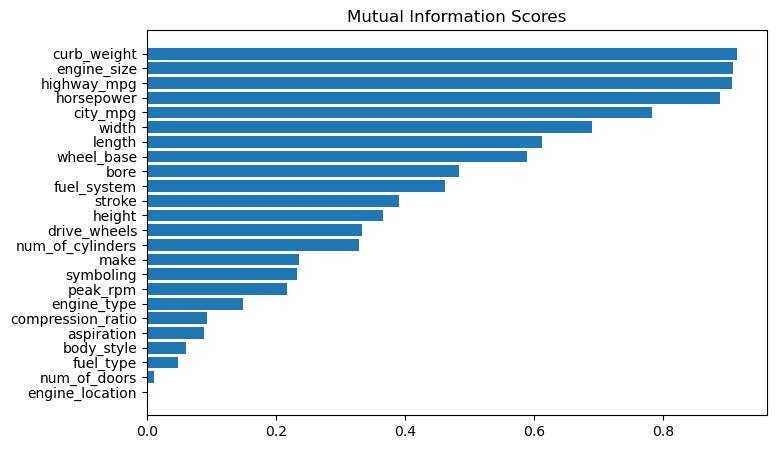

In [5]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with `price`, the target.


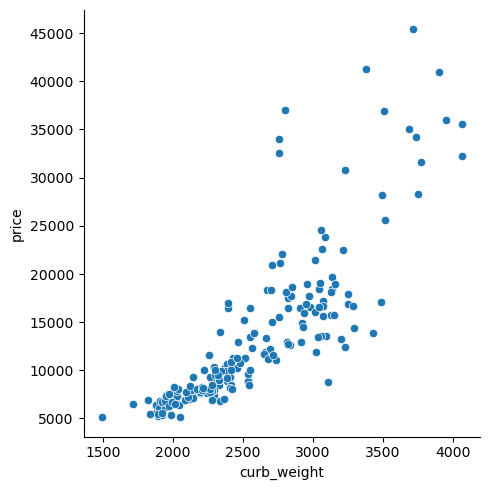

In [6]:
sns.relplot(x="curb_weight", y="price", data=df);

The `fuel_type` feature has a fairly low MI score, but as we can see from the figure, it clearly separates two `price` populations with different trends within the `horsepower` feature. This indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

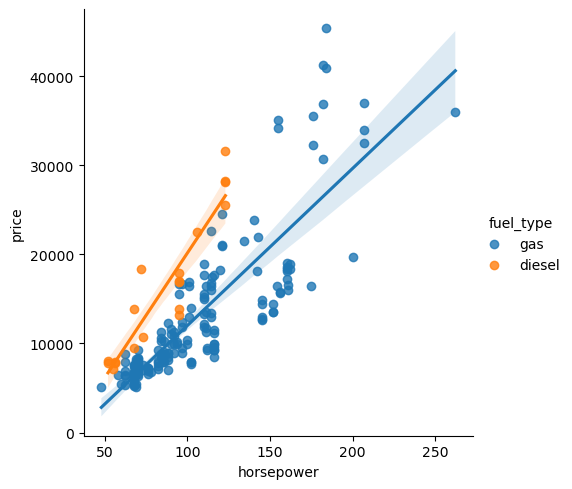

In [7]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

Data visualization is a great addition to your feature-engineering toolbox. Along with utility metrics like mutual information, visualizations like these can help you discover important relationships in your data.